# Processing Daily Climate Anomalies using 1982-2011 Climatology

**ABOUT:** Once the daily climatologies have been calculated for the reference period the next step is to subtract these climate means from the sea surface data observations for the full time series.



## Product 2. Daily Global Temperature Anomalies

General Workflow is to Load:
 1. Netcdf files containing observed SST from 1981-Present
 2. Netcdf containing 30-year Climatology Means for each day of the year
 
Next step is to pair each observed daily mean with the appropriate 30-year climatology and calculate the difference

In [1]:
# Libraries
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import netCDF4
import os
import oisstools as ot
 
# Set Notebook Options:
box_root = ot.set_workspace("local")
reference_period = "1982-2011"

# Set climatology source choices
climatologies = {"1982-2011" : "daily_clims_1982to2011.nc",
                 "1991-2020" : "daily_clims_1991to2020.nc"}

climate_period = climatologies[reference_period]

# document what choices were made on last run:
print(f"Working via directory at: {box_root}")
print(f"Calculating Anomalies for {reference_period} reference period using {climate_period}")

Working via directory at: /Users/akemberling/Box/
Calculating Anomalies for 1982-2011 reference period using daily_clims_1982to2011.nc


## Step 1: Open Daily Climatologies 

Daily climate means were calculated in the previous notebook: `01_BASE_Calc_Climatologies` for the 30-year reference period of 1982-2011. In the dimensions we see that the modified ordinal day is present in addition to lat/lon.

In [10]:
daily_clims = ot.load_oisst_climatology(box_root = box_root, 
                                        reference_period = reference_period)
#daily_clims

<xarray.Dataset>
Dimensions:               (lat: 720, lon: 1440, modified_ordinal_day: 366)
Coordinates:
  * lat                   (lat) float32 -89.875 -89.625 ... 89.625 89.875
  * lon                   (lon) float32 0.125 0.375 0.625 ... 359.625 359.875
  * modified_ordinal_day  (modified_ordinal_day) int64 1 2 3 4 ... 364 365 366
Data variables:
    sst                   (modified_ordinal_day, lat, lon) float32 ...
Attributes:
    title:          30-Year sea surface temperature climatology from NOAA OIS...
    institution:    Gulf of Maine Research Institute
    source:         NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/
    comment:        Climatologies represent mean SST for the years 1982-2011
    history:        Climatologies calculated 3/2/2020
    references:     https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oiss...
    dataset_title:  GMRI 30-Year Climatology - OISST

## Step 2: Load Netcdf Files for Daily SST Data
Lazy-load the annual netcdf files for the oisst sst data. Once again we will be taking advantage of {xarray} here to load them as a single object and not repeat steps for each year.

## Step 3: Re-create Modified Ordinal Day Index

To account for leap-years the daily climatology was calculated using a modified ordinal day, with which March 1st is always the 60th day of the of the index, with February 29th occupying the 59th value in the event that it occurs. In order to match the daily observations to these values we need an index of what day of the year it is (that isn't sensitive to leap-years) to match the observed sst values with the 30-year climatologies.

In [13]:
# Set Start and End Year to Load
start_year = 1981
end_year = 2021

#Load/append all the annual netcdf files
sst_obs = ot.load_box_oisst(box_root, 
                            start_year, 
                            end_year, 
                            anomalies = False, 
                            do_parallel = True)

# Add modified ordinal day, for day-to-day calculation and leapyear adjustment
# modified ordinal day function moved to oisstools module for consistency across notebooks
sst_obs = ot.add_mod(sst_obs, 'time')
sst_obs

,Array,Chunk
Bytes,60.18 GB,1.52 GB
Shape,"(14511, 720, 1440)","(366, 720, 1440)"
Count,123 Tasks,41 Chunks
Type,float32,numpy.ndarray


## Step 4: Validate Structure and matching convention

Critical here to make sure for the anomaly calculation that the correct climatology values are used when calculating the climate anomalies. The next few chunks just examine the array structures and the indexing of their values/

In [16]:
# # Does MOD align with the time coord? - Should be 61 for March 1st
# sst_obs.sel(time = '2000-03-01')["MOD"]

### Matching them up for arithmetic
So now the observed dataset contains the modified ordinal day of the year which we can use to match with the corresponding daily climatology

In [17]:
#sst_obs.sel(time = '2000-03-01')

In [18]:
# #### Foundation for ot.calc_anom

# # Choose a specific date to use as a tester
# test_day_obs = sst_obs.sel(time = '2000-03-01')

# # Now using that test day pull the climatology that should match it using MOD/
# test_day_clim = daily_clims.sel(modified_ordinal_day = test_day_obs["MOD"])

# # Last step is the subtraction of observed sst - climate mean
# test_day_anom = test_day_obs - test_day_clim

# # # rename to sst anomaly to indicate the math that took place
# test_day_anom = test_day_anom.rename_vars({'sst' : 'sst_anom'})
# test_day_anom

### Test Day Plot

As a proof  of concept that both the day of years align, and that anomalies look as they should, I like to plot March 1st as a test day. This date should be the 61st MOD and if things ran correctly we expect the color scale to center on 0 with familiar warm/cold anomaly patterns.

In [19]:
# fig = plt.figure(figsize=[12,5])

# ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))

# test_day_anom["sst_anom"].plot(
#     ax = ax,
#     levels = np.arange(-4.5, 6, 1.5),
#     extend = 'max',
#     transform = ccrs.PlateCarree())

# ax.coastlines()

# plt.show()

### How: GroupBy "time": split-apply-combine

So from the full daily set, we want to group by the time to split out each day. Then use the modified ordinal day to subtract the matching climatology. We won't need to worry about leap years because the matching is done with the MOD index.

In [20]:
# # Want to process each day on its own, so we will group by time
# sst_obs.groupby('time')

## Step 5: Calculate All Anomalies

This is the step where we apply the little subtraction function to all the dates we have. The result is the anomaly array we were after. First we define the function that will take a daily slice of the observed sst, and subtract it by its matching climatology. Then we use groupby().map() to apply it to all the groups.

In [21]:
# using oisstools module, subtract daily climatology that matches MOD
daily_anoms = sst_obs.groupby('time').map(lambda x: ot.calc_anom(x, daily_clims))
daily_anoms

,Array,Chunk
Bytes,60.18 GB,4.15 MB
Shape,"(14511, 720, 1440)","(1, 720, 1440)"
Count,58533 Tasks,14511 Chunks
Type,float32,numpy.ndarray


### Validation: Plot some Anomalies

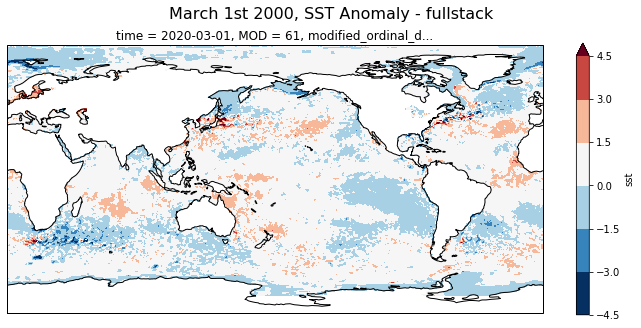

In [22]:
fig = plt.figure(figsize=[12,5])

ax = fig.add_subplot(111, projection = ccrs.PlateCarree(central_longitude = 180))
fig.suptitle('March 1st 2000, SST Anomaly - fullstack', fontsize = 16)

daily_anoms.sel(time = '2020-03-01').sst.plot(
    ax = ax,
    levels = np.arange(-4.5, 6, 1.5),
    extend = 'max',
    transform = ccrs.PlateCarree())

ax.coastlines()

plt.show()

Compare to the single day tester that we did outside of the slit-apply-combine function. 

## Plot Global Trend

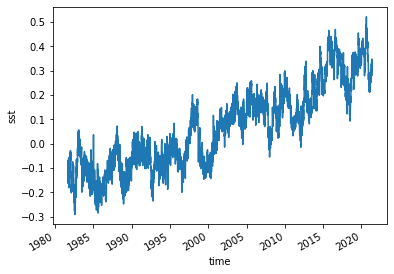

In [23]:
daily_anoms.sst.mean(["lon", "lat"]).plot()

# Update Metadata Attributes:

Just like with the climatology it is good to add metadata attributes to detail the different input sources, units, etc.

In [24]:
# Apply attributes - sets time encodings
daily_anoms = ot.apply_oisst_attributes(oisst_grid = daily_anoms, 
                                        anomalies = True, 
                                        reference_period = reference_period)
daily_anoms.attrs


{'title': 'Sea surface temperature anomalies from NOAA OISSTv2 SST Data using 1982-2011 Climatology',
 'institution': 'Gulf of Maine Research Institute',
 'source': 'NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/',
 'comment': 'Climatology used represents mean SST for the years 1982-2011',
 'history': 'Anomalies calculated 3/9/2021',
 'references': 'https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oisst.v2.highres.html',
 'dataset_title': 'Sea Surface Temperature Anomalies - OISSTv2'}

## Export Annual Files

In [25]:
# Export as annual netcdf files
# Save to box    
print(f"Made changes to anomalies folder, double check before saving")
for year, group in daily_anoms.groupby('time.year'):
    clim_folder = reference_period.replace("-", "to") + "_climatology"
    out_path = f'{box_root}RES_Data/OISST/oisst_mainstays/annual_anomalies/{clim_folder}/daily_anoms_{year}.nc'
      
    
    # Save them
    group.to_netcdf(out_path)
    print(f"Saving Anomalies for {year}, using {reference_period} climate reference period.")


Made changes to anomalies folder, double check before saving
Saving Anomalies for 1981, using 1982-2011 climate reference period.
Saving Anomalies for 1982, using 1982-2011 climate reference period.
Saving Anomalies for 1983, using 1982-2011 climate reference period.
Saving Anomalies for 1984, using 1982-2011 climate reference period.
Saving Anomalies for 1985, using 1982-2011 climate reference period.
Saving Anomalies for 1986, using 1982-2011 climate reference period.
Saving Anomalies for 1987, using 1982-2011 climate reference period.
Saving Anomalies for 1988, using 1982-2011 climate reference period.
Saving Anomalies for 1989, using 1982-2011 climate reference period.
Saving Anomalies for 1990, using 1982-2011 climate reference period.
Saving Anomalies for 1991, using 1982-2011 climate reference period.
Saving Anomalies for 1992, using 1982-2011 climate reference period.
Saving Anomalies for 1993, using 1982-2011 climate reference period.
Saving Anomalies for 1994, using 1982-2011